# Setup

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
# from tensorflow.keras import layers
import numpy as np
from numpy.random import default_rng
import scipy.linalg as la
from scipy.special import gammaln
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import netCDF4 as nc
import re
import pandas as pd
import sklearn as skl
import seaborn as sns
from tqdm.auto import tqdm
import tuning_fun as tu
import emulator_fun as ef
import time


In [2]:
# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# model

## read files

In [ ]:
case_name = 'rainshaftdt300'
base_path = '/Users/arthurhu/github/BOSS_PPE/summary_ncs/'
# base_path = '/pscratch/sd/a/arthurhu/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(39)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, filename, param_interest_idx)

nppe, npar = param_train['vals'].shape

n_input = param_train['vals'].shape[1]


In [4]:
dataset = nc.Dataset(base_path + filename, mode='r')
n_init = getattr(dataset, 'n_init')
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [5]:
n_tgt_ics = tgt_raw_vals[0].shape[0]
npar = n_input - n_init
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [6]:
ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
ncases = tgt_raw_vals[0].shape[0]
tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
    ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
    ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
    tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
    tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)


In [7]:
init_vars = getattr(dataset, 'init_var')
if isinstance(init_vars, str):
    init_vars = [init_vars]

initvar_matrix = []

for i_init, init_var in enumerate(init_vars):
    initvar_matrix.append(np.expand_dims(dataset.variables['case_' + init_var][:], axis=1))

tgt_sim_ics = np.concatenate(initvar_matrix, axis=1)

In [8]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

standscale = preprocessing.StandardScaler().fit(ppe_asinh)
ppe_all = standscale.transform(ppe_asinh)
tgt_all = standscale.transform(tgt_asinh)

x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, ppe_var_presence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, ppe_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

In [9]:
ppe_raw_vals[5].size/50000

516.0

(array([  53.,   64.,   36.,   27.,   36.,   29.,   35.,   23.,   31.,
          29.,   31.,   42.,   40.,   46.,   41.,   52.,   38.,   57.,
          63.,   67.,   71.,   74.,   97.,  113.,  123.,  134.,  239.,
         296.,  362.,  450.,  524.,  631.,  640.,  690.,  755.,  650.,
         629.,  620.,  587.,  559.,  521.,  467.,  377.,  268.,  219.,
         240.,  221.,  237.,  272.,  204.,  166.,  230.,  207.,  272.,
         185.,  229.,  196.,  138.,  146.,  164., 1894.,  163.,  197.,
         208.,  255.,  127.,  137.,  151.,  160.,  156.,  170.,  204.,
         217.,  256.,  211.,  160.,  189.,  243.,  281.,  357.,  291.,
         345.,  326.,  304.,  280.,  258.,   79.,   75.,   96.,  107.,
         131.,   81.,   83.,   86.,   99.,   97.,   47.,   41.,   44.,
          44.]),
 array([-2.23127226, -2.19427254, -2.15727283, -2.12027311, -2.0832734 ,
        -2.04627369, -2.00927397, -1.97227426, -1.93527454, -1.89827483,
        -1.86127512, -1.8242754 , -1.78727569, -1.750275

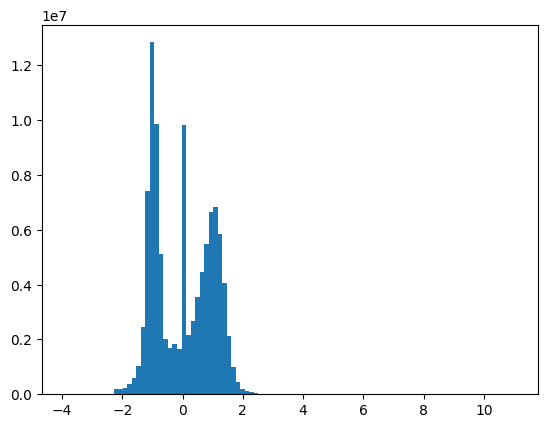

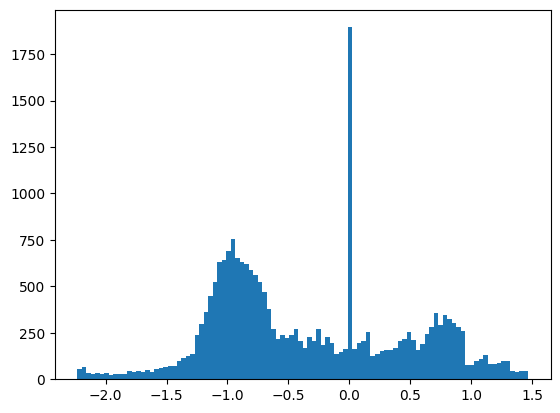

In [10]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 0
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(ppe_all[:,a+6:a+2580].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+6:a+2580].flatten(), bins=100)

In [11]:
# cc_model = tf.keras.models.load_model('condcoll_multioutput_try5_no_dropout.keras', compile=False)
cc_model = tf.keras.models.load_model('models/multioutput_try5_rainshaftdt300_M3069.keras', compile=False)


2025-05-22 19:03:06.666283: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-22 19:03:06.666308: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-22 19:03:06.666312: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1747954986.666679 67875868 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747954986.666720 67875868 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# REVIEW: check every time if this is true ... not sure how to implement this programatically
param_table = pd.read_csv('/Users/arthurhu/Library/Mobile Documents/com~apple~CloudDocs/storage/postdoc/CloudBOSS/param_consolid_RICO.csv')
# param_table = pd.read_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_RICO.csv')
param_names = param_table.columns[param_interest_idx + 1].to_list()
param_mean = param_table.values[0, param_interest_idx + 1].astype(np.float32)
param_std = param_table.values[1, param_interest_idx + 1].astype(np.float32)
# param_std[param_not_int_idx] = 0

## run

In [13]:
tfd = tfp.distributions
tfb = tfp.bijectors

nchains = 8
# tf.keras.backend.set_floatx('float32')
IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = minmaxscale.transform(IC_with_dummy)[:,:n_init].astype('float32')
valid_mask = tf.math.is_finite(tgt_all)
weights = np.ones([n_tgt_ics, nobs]).astype('float32')


In [14]:
params = tf.zeros(npar) + 0.5
params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
param_lp = tf.reduce_sum(tfd.Uniform(low=0.0,
                                     high=1.0).log_prob(params_2d))
input_norm = tf.concat([IC_norm, params_2d], axis=1) # n_tgt_ics x n_input
y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
obs_lps = tfd.Normal(loc=tf.cast(tgt_all, tf.float32), scale=1.).log_prob(tf.cast(y_emu[1], tf.float32))

eps = 1e-7
y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
valid_mask_float = tf.cast(valid_mask, tf.float32)
wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
wpresence_lp = tf.reduce_sum(wpresence_lps)

print(tf.reduce_sum(obs_lps), wpresence_lp)

tf.Tensor(-30633.0, shape=(), dtype=float32) tf.Tensor(-84265.31, shape=(), dtype=float32)


In [25]:
y_emu_wpresence, valid_mask_float

(<tf.Tensor: shape=(11, 2069), dtype=float32, numpy=
 array([[2.1438572e-13, 3.9915163e-02, 1.0000000e+00, ..., 4.2947068e-09,
         3.9494954e-09, 4.0854728e-09],
        [9.6840443e-14, 5.1749444e-01, 1.0000000e+00, ..., 2.5414690e-09,
         2.6229843e-09, 2.5908291e-09],
        [2.2687232e-16, 9.9999833e-01, 1.0000000e+00, ..., 4.3758619e-10,
         4.2351675e-10, 4.3044471e-10],
        ...,
        [6.6032958e-31, 1.0000000e+00, 1.0000000e+00, ..., 2.7014493e-10,
         2.8284822e-10, 2.5218871e-10],
        [2.2553580e-30, 1.0000000e+00, 1.0000000e+00, ..., 3.7681222e-10,
         3.9439527e-10, 3.4743575e-10],
        [3.3813823e-30, 1.0000000e+00, 1.0000000e+00, ..., 4.5442611e-10,
         4.7209958e-10, 4.1422948e-10]], dtype=float32)>,
 <tf.Tensor: shape=(11, 2069), dtype=float32, numpy=
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1

In [153]:
param_lps = []
obs_lps = []
wpresence_lps = []

for i in tqdm(range(1000)):
    initial_state = tf.random.normal([npar])
    # initial_state = tf.zeros(npar, dtype='float32')
    params_2d = tf.tile(initial_state[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))
    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs
    y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
    # FIXME: retrain the model usign logits to avoid arbitrary eps threshold
    eps = 1e-7
    y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
    valid_mask_float = tf.cast(valid_mask, tf.float32)
    wpresence_lp = tf.reduce_sum(tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float))
    y_emu_obs_norm = y_emu[1]
    y_emu_obs_norm_valid = tf.boolean_mask(y_emu_obs_norm, valid_mask)
    # y_emu_obs_norm_valid = tf.where(tf.math.is_nan(y_emu_obs_norm_valid), tf.constant(-20, dtype=y_emu_obs_norm_valid.dtype), y_emu_obs_norm_valid)
    tgt_all_valid = tf.boolean_mask(tgt_all, valid_mask)
    # weights_valid = tf.boolean_mask(weights, valid_mask)
    obs_lp = tf.reduce_sum(tfd.Normal(loc=tf.cast(tgt_all_valid, tf.float32), scale=10).log_prob(tf.cast(y_emu_obs_norm_valid, tf.float32)))
    param_lps.append(param_lp)
    obs_lps.append(obs_lp)
    wpresence_lps.append(wpresence_lp)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [162]:
np.std(param_lps), np.std(obs_lps), np.std(wpresence_lps)
s_obs = np.std(param_lps)/np.std(obs_lps)
s_wpr = np.std(param_lps)/np.std(wpresence_lps)

In [163]:
s_wpr

0.00011609521

In [167]:
sigma = 10
def toy_lp(params):
    # params = params_sigma[:-1]
    params_2d = tf.tile(params[None, :], [n_tgt_ics,1]) # n_tgt_ics x npar
    # param_lp = tf.reduce_sum(tfd.Uniform(low=tf.constant(0.0, dtype=tf.float32),
    #                                      high=tf.constant(1.0, dtype=tf.float32)).log_prob(params_2d))
    theta=tfb.Sigmoid().forward(params_2d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta))
    # # get sigma
    # log_sigma = params_sigma[-1]
    # sigma = tf.exp(log_sigma)
    # sigma_lp = tfd.Exponential(rate=0.5).log_prob(log_sigma) + log_sigma

    # get normalized ICs
    input_norm = tf.concat([IC_norm, theta], axis=1) # n_tgt_ics x n_input
    y_emu = cc_model(input_norm) # 2 * n_tgt_ics x nobs

    # emulated water presence
    y_emu_wpresence = tf.cast(y_emu[0], tf.float32)
    # FIXME: retrain the model usign logits to avoid arbitrary eps threshold
    eps = 1e-7
    y_emu_wpresence_clipped = tf.clip_by_value(y_emu_wpresence, eps, 1 - eps) # to avoid NaN in log likelihood
    valid_mask_float = tf.cast(valid_mask, tf.float32)
    wpresence_lps = tfp.distributions.Bernoulli(probs=y_emu_wpresence_clipped).log_prob(valid_mask_float)
    wpresence_lp = tf.reduce_sum(wpresence_lps)

    # emulated observed value
    y_emu_obs_norm = y_emu[1]
    y_emu_obs_norm_valid = tf.boolean_mask(y_emu_obs_norm, valid_mask)
    # y_emu_obs_norm_valid = tf.where(tf.math.is_nan(y_emu_obs_norm_valid), tf.constant(-20, dtype=y_emu_obs_norm_valid.dtype), y_emu_obs_norm_valid)
    tgt_all_valid = tf.boolean_mask(tgt_all, valid_mask)
    # weights_valid = tf.boolean_mask(weights, valid_mask)
    obs_lps = tfd.Normal(loc=tf.cast(tgt_all_valid, tf.float32), scale=sigma).log_prob(tf.cast(y_emu_obs_norm_valid, tf.float32)) #*weights_valid
    obs_lp = tf.reduce_sum(obs_lps)
    return param_lp + wpresence_lp * s_wpr + obs_lp * s_obs

batched_toy_lp = lambda params_batch: tf.vectorized_map(
toy_lp, params_batch)

num_burnin_steps = 5000
num_samples = 10000
initial_state = tf.random.normal([nchains, npar], seed=0)

stepsize = 0.01
# stepsize = tf.fill([nchains], stepsize)

# for stepsize in step_sizes:
hmc = tfp.mcmc.HamiltonianMonteCarlo(batched_toy_lp, step_size=stepsize, num_leapfrog_steps=3)
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=int(num_burnin_steps * 0.8))

    # for ikernel, kernel in enumerate([hmc, nuts, aptive_nuts, adaptive_hmc]):
# print(stepsize, ikernel)
start = time.time()
with tf.device('/CPU:0'):
    samples, kr = tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=adaptive_hmc,
        num_burnin_steps=num_burnin_steps,
        seed=0)

# test_run_samples.append(samples)
# test_run_kr.append(kr)
# test_run_step_sizes.append(stepsize)
# test_run_kernel.append(ikernel)
end = time.time()
print(end-start)
# test_run_time.append(end-start)


/Users/arthurhu/github/BOSS_PPE/.venv/lib/python3.10/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


: 

acceptance rate: [0.69 0.7  0.77 0.75 0.73 0.69 0.94 0.19]


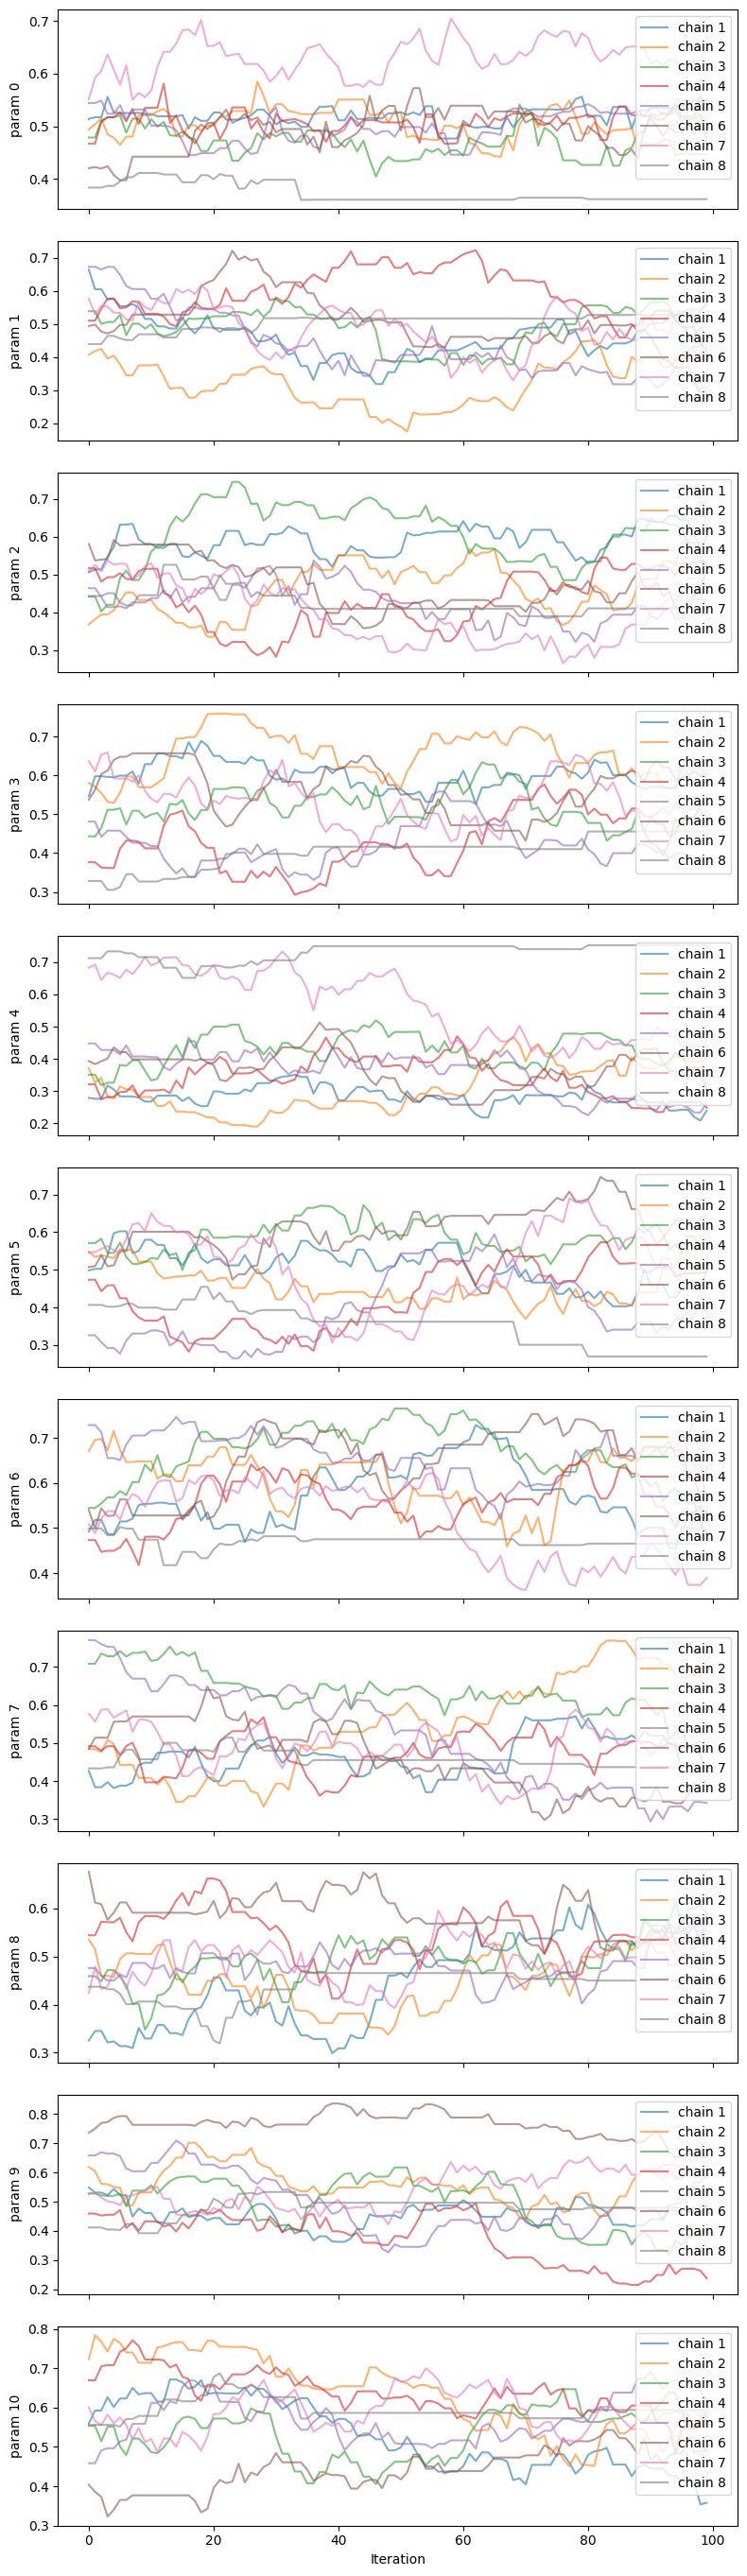

In [ ]:
# def toy_lp(x): return tfd.Normal(0.,1.).log_prob(x)
# hmc = tfp.mcmc.HamiltonianMonteCarlo(toy_lp, step_size=0.1, num_leapfrog_steps=3)
# samples, _ = tfp.mcmc.sample_chain(num_results=500, current_state=0., kernel=hmc, num_burnin_steps=200, seed=0)
# plt.plot(samples.numpy())  # should look fuzzy, not flat
# tfd.Normal(0.,1.).log_prob(0)
# tfd.Uniform(low=0.0, high=1.0).log_prob(1.)
# i = 7

# --- 4. Trace plots ---
def plot_traces(posterior, title):
    its, chains, dims = posterior.shape
    fig, axes = plt.subplots(dims, 1, figsize=(8, 2.5*dims), sharex=True)
    for d in range(dims):
        for c in range(chains):
            axes[d].plot(posterior[:,c,d], alpha=0.6, label=f'chain {c+1}')
        axes[d].set_ylabel(f'param {d}')
        axes[d].legend(loc='upper right')
    axes[-1].set_xlabel('Iteration')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
try:
    print("acceptance rate:", sum(kr.is_accepted.numpy())/num_samples)
except AttributeError:
    print("acceptance rate:", sum(kr.inner_results.is_accepted.numpy())/num_samples)
          
plot_traces(tfb.Sigmoid().forward(samples), "")
# kr

In [ ]:
# i=7
print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())
# print(test_run_kernel[i], test_run_step_sizes[i], test_run_time[i])

[[18.860868   5.8306847 18.322485   7.5805993 10.357703   4.7688174
   5.052823   8.478224   3.2261188 13.910274   3.004593 ]
 [10.032074   5.253853   8.312043   8.914811   3.5261784  6.6116185
   8.0179     3.1258981  5.3725543  8.214081   3.1048908]
 [13.064178   6.0828753  7.2430825  9.714478  11.222682   7.5056896
   5.3966866  5.0665884 10.162942   5.6912613  6.091173 ]
 [40.1865     4.687691   6.058067   4.843013   5.03424    3.4197984
   8.354782  12.76868    8.488054   4.1712947  4.5379376]
 [ 8.311225   4.2169485  4.4837413  7.6907625  4.160706   4.0482697
   4.8848014  2.9094803 10.580141   3.7564106  7.261155 ]
 [ 7.80738    5.3694377  4.3751464  7.7558365  7.2194915  4.7250223
   6.4685435  2.9732707  7.5221705  4.9950476  4.1757946]
 [18.314714  10.263957   4.023908  10.410303   2.9913116  5.2802896
   3.3865237 12.578265  11.723687   3.7888     9.643326 ]
 [ 3.8416076  4.3052883  4.553228   4.407237   4.474178   3.3516731
  13.921566   5.7366514  5.091274   6.746975   7.9

# postprocessing

In [ ]:
samples_bounded = tfb.Sigmoid().forward(samples)

In [ ]:
Na_norm = IC_norm[0,0].astype('float32')
Na_col = tf.fill([tf.shape(samples_bounded)[0], 1], Na_norm)
Na_col3d = tf.tile(Na_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([Na_col3d, samples_bounded], axis=2)
# w_norm = IC_norm[0,1].astype('float32')
# w_col = tf.fill([tf.shape(samples_bounded)[0], 1], w_norm)

In [ ]:
samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = minmaxscale.inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

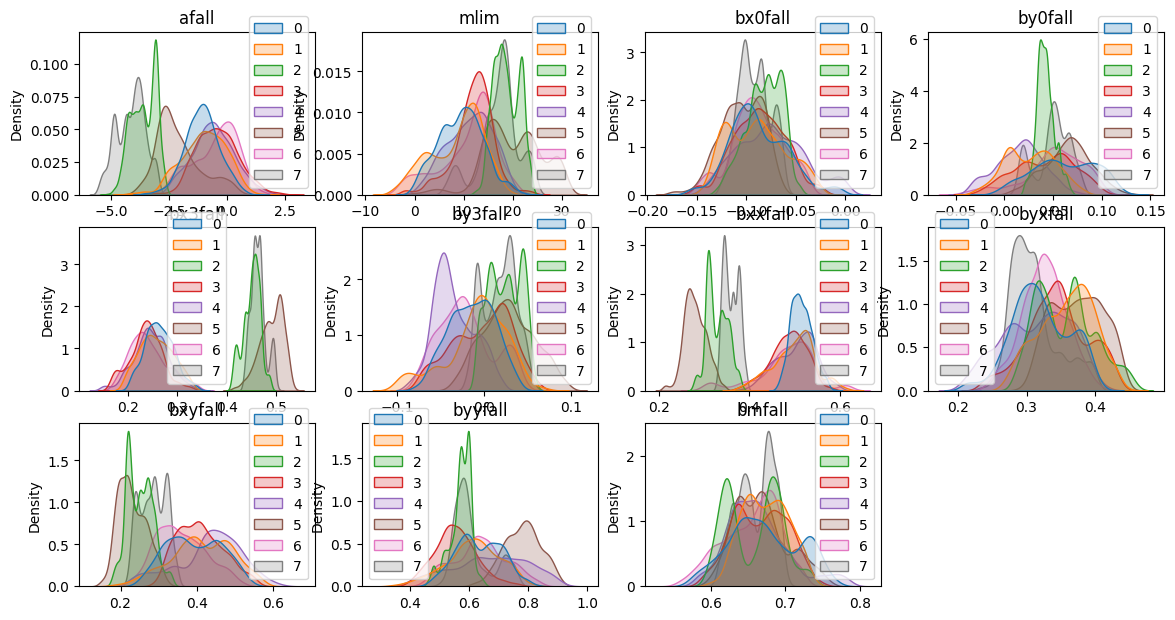

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_raw_vals.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    if ipost < len(param_names):
        param_name = param_names[ipost]
    else:
        param_name = 'sigma'
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_raw_vals[:,:,ipost], fill=True)
    plt.title(param_name)
    # plt.plot((param_mean[iparam], param_mean[iparam]), ax.get_ylim(), color='tab:red')

plt.show()


##  save distribution for PPE

In [337]:
samples_raw_vals.shape

(10000, 8, 11)

In [362]:
nbins = 50
count = {}
bins = {}
sample_sum_chains = samples_raw_vals.reshape(80000,11)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

In [364]:
pd.DataFrame.from_dict(count).to_csv('MCMC_posterior/' + case_name + '_r0_param_density_AHMC.csv', index=False)
pd.DataFrame.from_dict(bins).to_csv('MCMC_posterior/' + case_name + '_r0_param_bins_AHMC.csv', index=False)

In [365]:
case_name

'rainshaftdt300'

## update params csv

In [ ]:
original_params = pd.read_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_RICO.csv')
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    updated_params.loc[0, param_name] = weighted_mean

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv('/global/u2/a/arthurhu/Cloud_BOSS/param_consolid_AHMC.csv', index=False)

## validation

In [40]:
IC_norm

array([[0.02167574, 0.02168023],
       [0.02167574, 0.13038467],
       [0.02167574, 0.34779352],
       [0.02167574, 0.78261125],
       [0.13038498, 0.02168023],
       [0.13038498, 0.13038467],
       [0.13038498, 0.34779352],
       [0.13038498, 0.78261125],
       [0.34780347, 0.02168023],
       [0.34780347, 0.13038467],
       [0.34780347, 0.34779352],
       [0.34780347, 0.78261125],
       [0.78264046, 0.02168023],
       [0.78264046, 0.13038467],
       [0.78264046, 0.34779352],
       [0.78264046, 0.78261125]], dtype=float32)

In [54]:
meanresult = np.mean(samples, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [16, 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)
vars_after_MCMC_norm = cc_model(meanresults_incl_ics)


In [42]:
y_predict = vars_after_MCMC_norm[1][valid_mask]
y_true = tgt_all[valid_mask]

In [56]:
vars_after_MCMC_norm[1].shape

TensorShape([16, 14404])

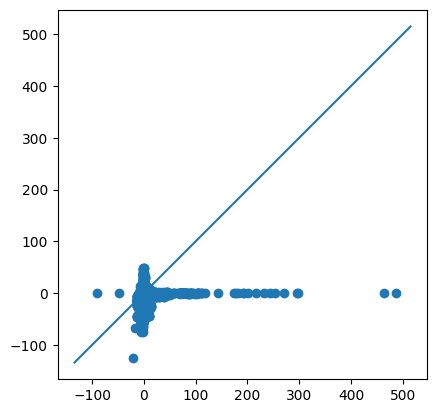

In [46]:
plt.scatter(y_true, y_predict)
ax = plt.gca()
ax.set_aspect('equal')
ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
plt.plot([ax_min, ax_max], [ax_min, ax_max])
# plt.xscale('log')
# plt.yscale('log')
